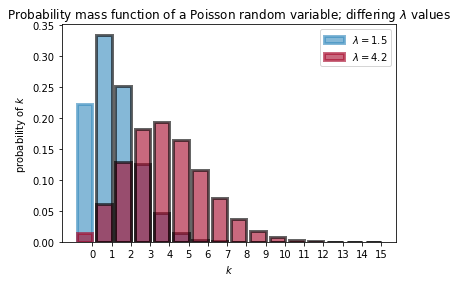

In [6]:
%matplotlib inline

from IPython.core.pylabtools import figsize
import numpy as np
from matplotlib import pyplot as plt

import scipy.stats as stats
a = np.arange(16)
poi = stats.poisson
lambda_ = [1.5, 4.25]
colours = ["#348ABD", "#A60628"]

plt.bar(a, poi.pmf(a, lambda_[0]), color=colours[0],
        label="$\lambda = %.1f$" % lambda_[0], alpha=0.60,
        edgecolor=colours[0], lw="3")

plt.bar(a, poi.pmf(a, lambda_[1]), color=colours[1],
        label="$\lambda = %.1f$" % lambda_[1], alpha=0.60,
        edgecolor=colours[1], lw="3")

plt.xticks(a + 0.4, a)
plt.legend()
plt.ylabel("probability of $k$")
plt.xlabel("$k$")
plt.title("Probability mass function of a Poisson random variable; differing \
$\lambda$ values");

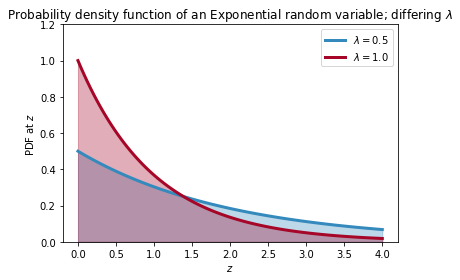

In [5]:

a = np.linspace(0, 4, 100)
expo = stats.expon
lambda_ = [0.5, 1]

for l, c in zip(lambda_, colours):
    plt.plot(a, expo.pdf(a, scale=1. / l), lw=3,
             color=c, label="$\lambda = %.1f$" % l)
    plt.fill_between(a, expo.pdf(a, scale=1. / l), color=c, alpha=.33)

plt.legend()
plt.ylabel("PDF at $z$")
plt.xlabel("$z$")
plt.ylim(0, 1.2)
plt.title("Probability density function of an Exponential random variable;\
 differing $\lambda$");

In [8]:
count_data = np.loadtxt("datatxtdata.csv")

In [9]:
count_data

array([ 13.,  24.,   8.,  24.,   7.,  35.,  14.,  11.,  15.,  11.,  22.,
        22.,  11.,  57.,  11.,  19.,  29.,   6.,  19.,  12.,  22.,  12.,
        18.,  72.,  32.,   9.,   7.,  13.,  19.,  23.,  27.,  20.,   6.,
        17.,  13.,  10.,  14.,   6.,  16.,  15.,   7.,   2.,  15.,  15.,
        19.,  70.,  49.,   7.,  53.,  22.,  21.,  31.,  19.,  11.,  18.,
        20.,  12.,  35.,  17.,  23.,  17.,   4.,   2.,  31.,  30.,  13.,
        27.,   0.,  39.,  37.,   5.,  14.,  13.,  22.])

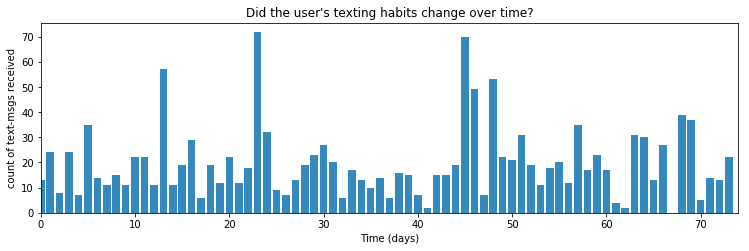

In [11]:
figsize(12.5, 3.5)
count_data = np.loadtxt("datatxtdata.csv")
n_count_data = len(count_data)
plt.bar(np.arange(n_count_data), count_data, color="#348ABD")
plt.xlabel("Time (days)")
plt.ylabel("count of text-msgs received")
plt.title("Did the user's texting habits change over time?")
plt.xlim(0, n_count_data);

In [12]:
import pymc as pm

alpha = 1.0 / count_data.mean()  # Recall count_data is the
                               # variable that holds our txt counts
lambda_1 = pm.Exponential("lambda_1", alpha)
lambda_2 = pm.Exponential("lambda_2", alpha)

tau = pm.DiscreteUniform("tau", lower=0, upper=n_count_data)

In [14]:
print("Random output:", tau.random(), tau.random(), tau.random())

Random output: 11 74 28


In [15]:
@pm.deterministic
def lambda_(tau=tau, lambda_1=lambda_1, lambda_2=lambda_2):
    out = np.zeros(n_count_data)
    out[:tau] = lambda_1  # lambda before tau is lambda1
    out[tau:] = lambda_2  # lambda after (and including) tau is lambda2
    return out

In [16]:
observation = pm.Poisson("obs", lambda_, value=count_data, observed=True)

model = pm.Model([observation, lambda_1, lambda_2, tau])

In [17]:
# Mysterious code to be explained in Chapter 3.
mcmc = pm.MCMC(model)
mcmc.sample(40000, 10000, 1)

 [-----------------100%-----------------] 40000 of 40000 complete in 5.7 sec

In [18]:

lambda_1_samples = mcmc.trace('lambda_1')[:]
lambda_2_samples = mcmc.trace('lambda_2')[:]
tau_samples = mcmc.trace('tau')[:]

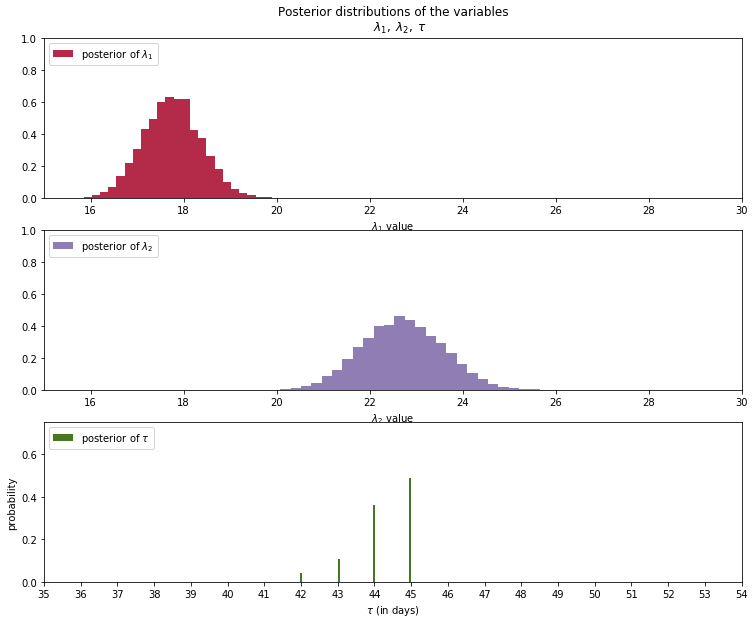

In [19]:
figsize(12.5, 10)
# histogram of the samples:

ax = plt.subplot(311)
ax.set_autoscaley_on(False)

plt.hist(lambda_1_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_1$", color="#A60628", normed=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the variables
    $\lambda_1,\;\lambda_2,\;\tau$""")
plt.xlim([15, 30])
plt.xlabel("$\lambda_1$ value")

ax = plt.subplot(312)
ax.set_autoscaley_on(False)
plt.hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_2$", color="#7A68A6", normed=True)
plt.legend(loc="upper left")
plt.xlim([15, 30])
plt.xlabel("$\lambda_2$ value")

plt.subplot(313)
w = 1.0 / tau_samples.shape[0] * np.ones_like(tau_samples)
plt.hist(tau_samples, bins=n_count_data, alpha=1,
         label=r"posterior of $\tau$",
         color="#467821", weights=w, rwidth=2.)
plt.xticks(np.arange(n_count_data))

plt.legend(loc="upper left")
plt.ylim([0, .75])
plt.xlim([35, len(count_data) - 20])
plt.xlabel(r"$\tau$ (in days)")
plt.ylabel("probability");

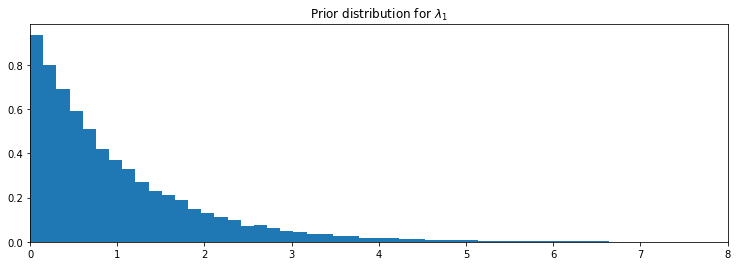

In [25]:
from IPython.core.pylabtools import figsize
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
figsize(12.5, 4)

lambda_1 = pm.Exponential("lambda_1", 1) 
samples = [lambda_1.random() for i in range(20000)]
plt.hist(samples, bins=70, normed=True, histtype="stepfilled")

plt.title("Prior distribution for $\lambda_1$")

plt.xlim(0, 8);

In [26]:
data = np.array([10, 5])
fixed_variable = pm.Poisson("fxd", 1, value=data, observed=True)
print("value: ", fixed_variable.value)
print("calling .random()")
fixed_variable.random()
print("value: ", fixed_variable.value)

value:  [10  5]
calling .random()
value:  [10  5]


In [29]:

lambda_1 = pm.Exponential("lambda_1", 1)  # prior on first behaviour
lambda_2 = pm.Exponential("lambda_2", 1)  # prior on second behaviour
tau = pm.DiscreteUniform("tau", lower=0, upper=10)  # prior on behaviour change

print("lambda_1.value = %.3f" % lambda_1.value)
print("lambda_2.value = %.3f" % lambda_2.value)
print("tau.value = %.3f" % tau.value, "\n")

lambda_1.random(), lambda_2.random(), tau.random()




print("After calling random() on the variables...")
print("lambda_1.value = %.3f" % lambda_1.value)
print("lambda_2.value = %.3f" % lambda_2.value)
print("tau.value = %.3f" % tau.value)



import numpy as np
n_data_points = 5  # in CH1 we had ~70 data points


@pm.deterministic
def lambda_(tau=tau, lambda_1=lambda_1, lambda_2=lambda_2):
    out = np.zeros(n_data_points)
    out[:tau] = lambda_1  # lambda before tau is lambda1
    out[tau:] = lambda_2  # lambda after tau is lambda2
    return out


# We're using some fake data here
data = np.array([10, 25, 15, 20, 35])
obs = pm.Poisson("obs", lambda_, value=data, observed=True)
print(obs.value)

lambda_1.value = 0.082
lambda_2.value = 0.910
tau.value = 9.000 

After calling random() on the variables...
lambda_1.value = 0.306
lambda_2.value = 0.845
tau.value = 8.000
[10 25 15 20 35]


In [60]:

tau = pm.rdiscrete_uniform(0, 80)
print(tau)

27


In [72]:

alpha = 1. / 20.
lambda_1, lambda_2 = pm.rexponential(alpha, 2)
print(lambda_1, lambda_2)
print(alpha)

25.5678362501 8.89898105858
0.05


In [73]:

data = np.r_[pm.rpoisson(lambda_1, tau), pm.rpoisson(lambda_2, 80 - tau)]
print(data)

[28 33 21 31 27 25 36 20 25 14 23 28 29 24 37 26 26 23 34 28 26 22 23 23 28
 27 26  7 10  8  6  4 11  8 10  8  8  2  6  8 11  8  9 11  6 11 10  9  6  5
  6 12  6 14  9 10  4 14 11 18  3  9  7 16  9 11 12  9  7  4  6 11  6 11 11
  7  7  6  6 13]


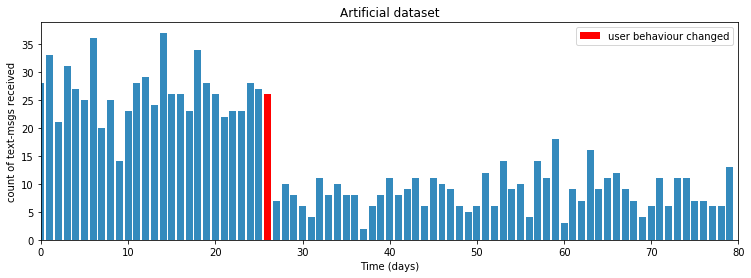

In [74]:
plt.bar(np.arange(80), data, color="#348ABD")
plt.bar(tau - 1, data[tau - 1], color="r", label="user behaviour changed")
plt.xlabel("Time (days)")
plt.ylabel("count of text-msgs received")
plt.title("Artificial dataset")
plt.xlim(0, 80)
plt.legend();

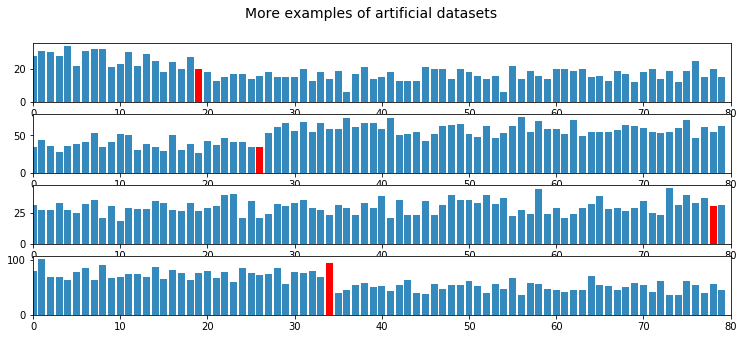

In [77]:

def plot_artificial_sms_dataset():
    tau = pm.rdiscrete_uniform(0, 80)
    alpha = 1. / 20.
    lambda_1, lambda_2 = pm.rexponential(alpha, 2)
    data = np.r_[pm.rpoisson(lambda_1, tau), pm.rpoisson(lambda_2, 80 - tau)]
    plt.bar(np.arange(80), data, color="#348ABD")
    plt.bar(tau - 1, data[tau - 1], color="r", label="user behaviour changed")
    plt.xlim(0, 80)

figsize(12.5, 5)
plt.suptitle("More examples of artificial datasets", fontsize=14)
for i in range(1, 5):
    plt.subplot(4, 1, i)
    plot_artificial_sms_dataset()

In [78]:
import pymc as pm

# The parameters are the bounds of the Uniform.
p = pm.Uniform('p', lower=0, upper=1)

In [90]:
# set constants
p_true = 0.05  # remember, this is unknown.
N = 1500

# sample N Bernoulli random variables from Ber(0.05).
# each random variable has a 0.05 chance of being a 1.
# this is the data-generation step
occurrences = pm.rbernoulli(p_true, N)

print(occurrences)  # Remember: Python treats True == 1, and False == 0
print(occurrences.sum())


[False False False ..., False  True False]
71


In [91]:
# Occurrences.mean is equal to n/N.
print("What is the observed frequency in Group A? %.4f" % occurrences.mean())
print("Does this equal the true frequency? %s" % (occurrences.mean() == p_true))

What is the observed frequency in Group A? 0.0473
Does this equal the true frequency? False


In [92]:
# include the observations, which are Bernoulli
obs = pm.Bernoulli("obs", p, value=occurrences, observed=True)

# To be explained in chapter 3
mcmc = pm.MCMC([p, obs])
mcmc.sample(18000, 1000)

 [-----------------100%-----------------] 18000 of 18000 complete in 1.1 sec

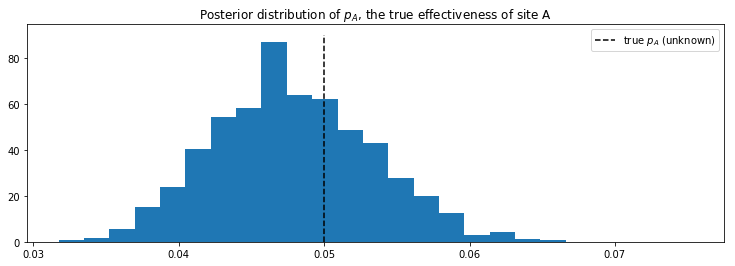

In [93]:
figsize(12.5, 4)
plt.title("Posterior distribution of $p_A$, the true effectiveness of site A")
plt.vlines(p_true, 0, 90, linestyle="--", label="true $p_A$ (unknown)")
plt.hist(mcmc.trace("p")[:], bins=25, histtype="stepfilled", normed=True)
plt.legend();

In [100]:
import pymc as pm
figsize(12, 4)

# these two quantities are unknown to us.
true_p_A = 0.05
true_p_B = 0.04

# notice the unequal sample sizes -- no problem in Bayesian analysis.
N_A = 1500
N_B = 750

# generate some observations
observations_A = pm.rbernoulli(true_p_A, N_A)
observations_B = pm.rbernoulli(true_p_B, N_B)
print("Obs from Site A: ", observations_A[:30].astype(int), "...")
print("Obs from Site B: ", observations_B[:30].astype(int), "...")

Obs from Site A:  [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0] ...
Obs from Site B:  [0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] ...


In [101]:

print(observations_A.mean())
print(observations_B.mean())

0.0526666666667
0.0333333333333


In [103]:
# Set up the pymc model. Again assume Uniform priors for p_A and p_B.
p_A = pm.Uniform("p_A", 0, 1)
p_B = pm.Uniform("p_B", 0, 1)


# Define the deterministic delta function. This is our unknown of interest.
@pm.deterministic
def delta(p_A=p_A, p_B=p_B):
    return p_A - p_B

# Set of observations, in this case we have two observation datasets.
obs_A = pm.Bernoulli("obs_A", p_A, value=observations_A, observed=True)
obs_B = pm.Bernoulli("obs_B", p_B, value=observations_B, observed=True)

# To be explained in chapter 3.
mcmc = pm.MCMC([p_A, p_B, delta, obs_A, obs_B])
mcmc.sample(20000, 1000)

 [-----------------100%-----------------] 20000 of 20000 complete in 2.0 sec

In [108]:
class MyClass:
    def set_value(self, text):  # クラス内の value 変数に値を代入するメソッド
        self.value = text
 
    def print_value(self):      # 変数 value の値を表示するメソッド
        print(self.value) 
        
if __name__ == "__main__":      #直接実行された場合のみ実行し、それ以外の場合は実行しない の意味
    a = MyClass()               # MyClass のインスタンスを生成
    a.set_value("abc")          # 変数 value に文字列 "abc" を代入 
    a.print_value()             # abc        

abc


In [106]:
class MyClass:
    def __init__(self, text):   # インスタンス生成時に自動的に呼ばれるメソッド
        self.value = text
 
    def print_value(self):      # 変数 value の値を表示するメソッド
        print(self.value)

if __name__ == "__main__":
    a = MyClass("abc")          # MyClass のインスタンスを生成
    a.print_value()             # abc

abc


In [110]:
#クラス内の関数をメソッドと呼びます。メソッドの宣言は、クラス外と同じようにdefを使用して宣言します。

In [111]:
p_A_samples = mcmc.trace("p_A")[:]
p_B_samples = mcmc.trace("p_B")[:]
delta_samples = mcmc.trace("delta")[:]

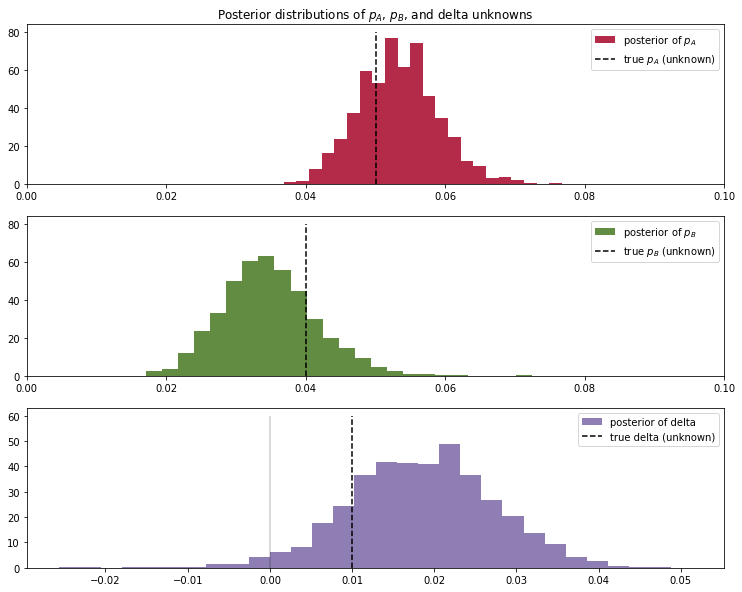

In [112]:

figsize(12.5, 10)

# histogram of posteriors

ax = plt.subplot(311)

plt.xlim(0, .1)
plt.hist(p_A_samples, histtype='stepfilled', bins=25, alpha=0.85,
         label="posterior of $p_A$", color="#A60628", normed=True)
plt.vlines(true_p_A, 0, 80, linestyle="--", label="true $p_A$ (unknown)")
plt.legend(loc="upper right")
plt.title("Posterior distributions of $p_A$, $p_B$, and delta unknowns")

ax = plt.subplot(312)

plt.xlim(0, .1)
plt.hist(p_B_samples, histtype='stepfilled', bins=25, alpha=0.85,
         label="posterior of $p_B$", color="#467821", normed=True)
plt.vlines(true_p_B, 0, 80, linestyle="--", label="true $p_B$ (unknown)")
plt.legend(loc="upper right")

ax = plt.subplot(313)
plt.hist(delta_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of delta", color="#7A68A6", normed=True)
plt.vlines(true_p_A - true_p_B, 0, 60, linestyle="--",
           label="true delta (unknown)")
plt.vlines(0, 0, 60, color="black", alpha=0.2)
plt.legend(loc="upper right");

In [113]:

# Count the number of samples less than 0, i.e. the area under the curve
# before 0, represent the probability that site A is worse than site B.
print("Probability site A is WORSE than site B: %.3f" % \
    (delta_samples < 0).mean())

print("Probability site A is BETTER than site B: %.3f" % \
    (delta_samples > 0).mean())

Probability site A is WORSE than site B: 0.023
Probability site A is BETTER than site B: 0.977


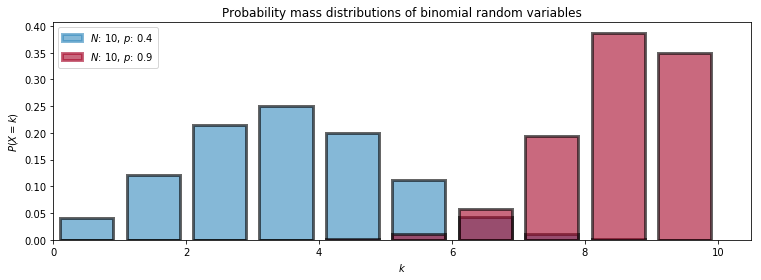

In [114]:

figsize(12.5, 4)

import scipy.stats as stats
binomial = stats.binom

parameters = [(10, .4), (10, .9)]
colors = ["#348ABD", "#A60628"]

for i in range(2):
    N, p = parameters[i]
    _x = np.arange(N + 1)
    plt.bar(_x - 0.5, binomial.pmf(_x, N, p), color=colors[i],
            edgecolor=colors[i],
            alpha=0.6,
            label="$N$: %d, $p$: %.1f" % (N, p),
            linewidth=3)

plt.legend(loc="upper left")
plt.xlim(0, 10.5)
plt.xlabel("$k$")
plt.ylabel("$P(X = k)$")
plt.title("Probability mass distributions of binomial random variables");

Temp (F), O-Ring failure?
[[ 66.   0.]
 [ 70.   1.]
 [ 69.   0.]
 [ 68.   0.]
 [ 67.   0.]
 [ 72.   0.]
 [ 73.   0.]
 [ 70.   0.]
 [ 57.   1.]
 [ 63.   1.]
 [ 70.   1.]
 [ 78.   0.]
 [ 67.   0.]
 [ 53.   1.]
 [ 67.   0.]
 [ 75.   0.]
 [ 70.   0.]
 [ 81.   0.]
 [ 76.   0.]
 [ 79.   0.]
 [ 75.   1.]
 [ 76.   0.]
 [ 58.   1.]]


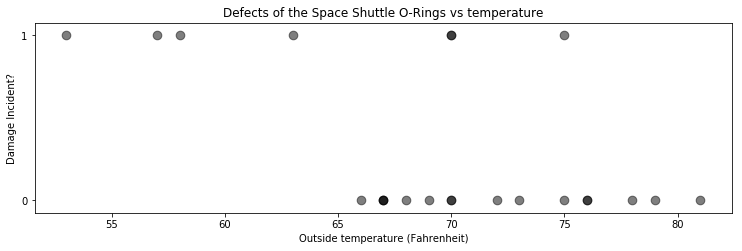

In [116]:
figsize(12.5, 3.5)
np.set_printoptions(precision=3, suppress=True)
challenger_data = np.genfromtxt("challenger_data.csv", skip_header=1,
                                usecols=[1, 2], missing_values="NA",
                                delimiter=",")
# drop the NA values
challenger_data = challenger_data[~np.isnan(challenger_data[:, 1])]

# plot it, as a function of temperature (the first column)
print("Temp (F), O-Ring failure?")
print(challenger_data)

plt.scatter(challenger_data[:, 0], challenger_data[:, 1], s=75, color="k",
            alpha=0.5)
plt.yticks([0, 1])
plt.ylabel("Damage Incident?")
plt.xlabel("Outside temperature (Fahrenheit)")
plt.title("Defects of the Space Shuttle O-Rings vs temperature");

In [117]:
import pymc as pm

temperature = challenger_data[:, 0]
D = challenger_data[:, 1]  # defect or not?

# notice the`value` here. We explain why below.
beta = pm.Normal("beta", 0, 0.001, value=0)
alpha = pm.Normal("alpha", 0, 0.001, value=0)


@pm.deterministic
def p(t=temperature, alpha=alpha, beta=beta):
    return 1.0 / (1. + np.exp(beta * t + alpha))

In [118]:
p.value

array([ 0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,
        0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,
        0.5])

In [127]:

# connect the probabilities in `p` with our observations through a
# Bernoulli random variable.
observed = pm.Bernoulli("bernoulli_obs", p, value=D, observed=True)

model = pm.Model([observed, beta, alpha])

# Mysterious code to be explained in Chapter 3
map_ = pm.MAP(model)
map_.fit()
mcmc = pm.MCMC(model)
mcmc.sample(120000, 100000, 2)

 [-----------------100%-----------------] 120000 of 120000 complete in 10.6 sec

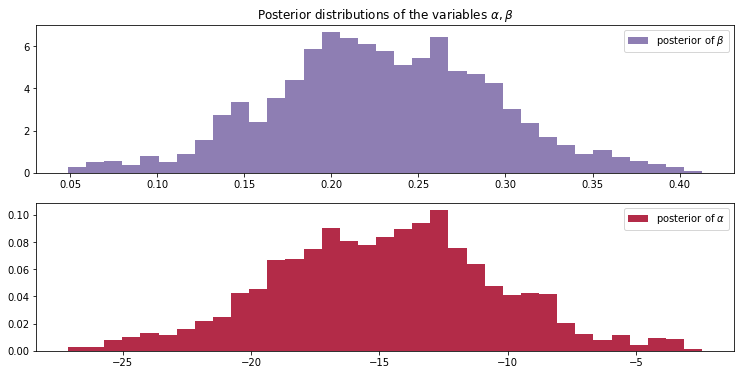

In [128]:
alpha_samples = mcmc.trace('alpha')[:, None]  # best to make them 1d
beta_samples = mcmc.trace('beta')[:, None]

figsize(12.5, 6)

# histogram of the samples:
plt.subplot(211)
plt.title(r"Posterior distributions of the variables $\alpha, \beta$")
plt.hist(beta_samples, histtype='stepfilled', bins=35, alpha=0.85,
         label=r"posterior of $\beta$", color="#7A68A6", normed=True)
plt.legend()

plt.subplot(212)
plt.hist(alpha_samples, histtype='stepfilled', bins=35, alpha=0.85,
         label=r"posterior of $\alpha$", color="#A60628", normed=True)
plt.legend();

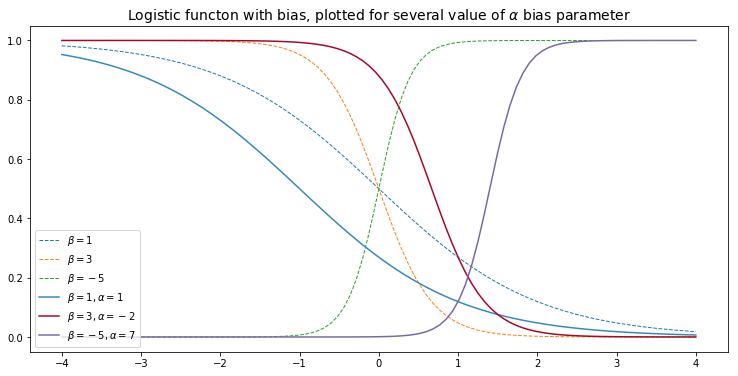

In [129]:
def logistic(x, beta, alpha=0):
    return 1.0 / (1.0 + np.exp(np.dot(beta, x) + alpha))

x = np.linspace(-4, 4, 100)

plt.plot(x, logistic(x, 1), label=r"$\beta = 1$", ls="--", lw=1)
plt.plot(x, logistic(x, 3), label=r"$\beta = 3$", ls="--", lw=1)
plt.plot(x, logistic(x, -5), label=r"$\beta = -5$", ls="--", lw=1)

plt.plot(x, logistic(x, 1, 1), label=r"$\beta = 1, \alpha = 1$",
         color="#348ABD")
plt.plot(x, logistic(x, 3, -2), label=r"$\beta = 3, \alpha = -2$",
         color="#A60628")
plt.plot(x, logistic(x, -5, 7), label=r"$\beta = -5, \alpha = 7$",
         color="#7A68A6")

plt.title("Logistic functon with bias, plotted for several value of $\\alpha$ bias parameter", fontsize=14)
plt.legend(loc="lower left");

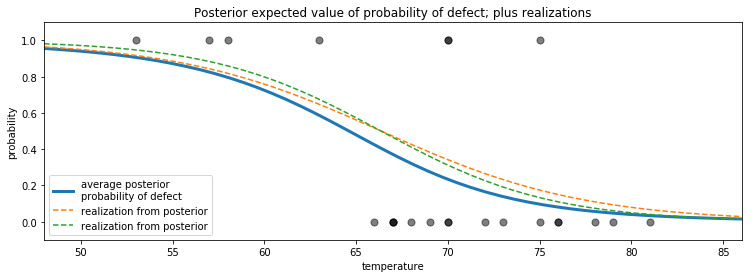

In [130]:
t = np.linspace(temperature.min() - 5, temperature.max() + 5, 50)[:, None]
p_t = logistic(t.T, beta_samples, alpha_samples)

mean_prob_t = p_t.mean(axis=0)
figsize(12.5, 4)

plt.plot(t, mean_prob_t, lw=3, label="average posterior \nprobability \
of defect")
plt.plot(t, p_t[0, :], ls="--", label="realization from posterior")
plt.plot(t, p_t[-2, :], ls="--", label="realization from posterior")
plt.scatter(temperature, D, color="k", s=50, alpha=0.5)
plt.title("Posterior expected value of probability of defect; \
plus realizations")
plt.legend(loc="lower left")
plt.ylim(-0.1, 1.1)
plt.xlim(t.min(), t.max())
plt.ylabel("probability")
plt.xlabel("temperature");

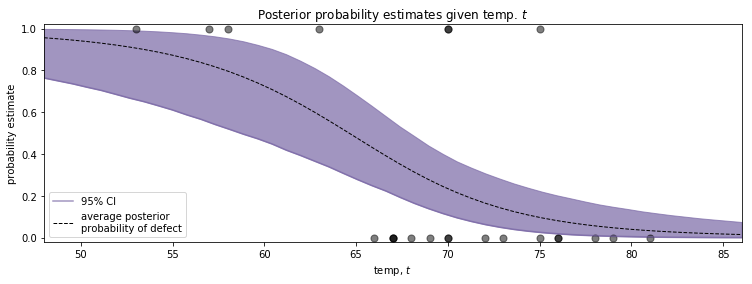

In [131]:
from scipy.stats.mstats import mquantiles

# vectorized bottom and top 2.5% quantiles for "confidence interval"
qs = mquantiles(p_t, [0.025, 0.975], axis=0)
plt.fill_between(t[:, 0], *qs, alpha=0.7,
                 color="#7A68A6")

plt.plot(t[:, 0], qs[0], label="95% CI", color="#7A68A6", alpha=0.7)

plt.plot(t, mean_prob_t, lw=1, ls="--", color="k",
         label="average posterior \nprobability of defect")

plt.xlim(t.min(), t.max())
plt.ylim(-0.02, 1.02)
plt.legend(loc="lower left")
plt.scatter(temperature, D, color="k", s=50, alpha=0.5)
plt.xlabel("temp, $t$")

plt.ylabel("probability estimate")
plt.title("Posterior probability estimates given temp. $t$");

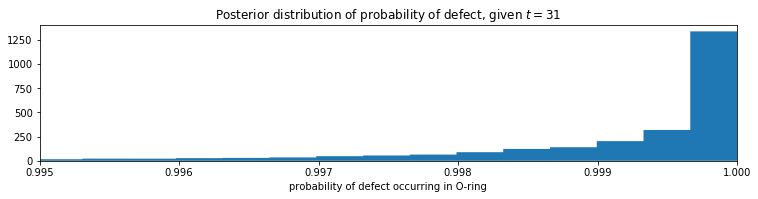

In [132]:
figsize(12.5, 2.5)

prob_31 = logistic(31, beta_samples, alpha_samples)

plt.xlim(0.995, 1)
plt.hist(prob_31, bins=1000, normed=True, histtype='stepfilled')
plt.title("Posterior distribution of probability of defect, given $t = 31$")
plt.xlabel("probability of defect occurring in O-ring");

In [135]:
simulated = pm.Bernoulli("bernoulli_sim", p)
N = 10000

mcmc = pm.MCMC([simulated, alpha, beta, observed])
mcmc.sample(N)

 [-----------------100%-----------------] 10000 of 10000 complete in 1.9 sec

(10000, 23)


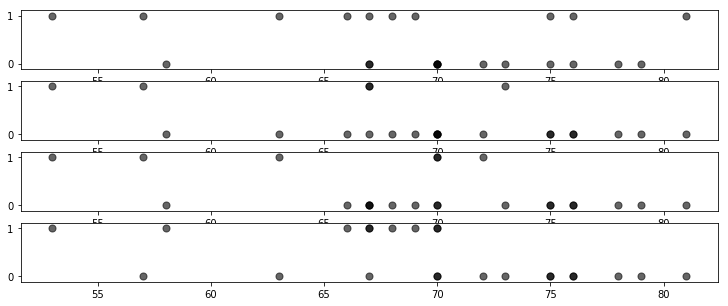

In [136]:
figsize(12.5, 5)

simulations = mcmc.trace("bernoulli_sim")[:]
print(simulations.shape)

plt.title("Simulated dataset using posterior parameters")
figsize(12.5, 6)
for i in range(4):
    ax = plt.subplot(4, 1, i + 1)
    plt.scatter(temperature, simulations[1000 * i, :], color="k",
                s=50, alpha=0.6)

In [137]:
posterior_probability = simulations.mean(axis=0)
print("posterior prob of defect | realized defect ")
for i in range(len(D)):
    print("%.2f                     |   %d" % (posterior_probability[i], D[i]))

posterior prob of defect | realized defect 
0.44                     |   0
0.28                     |   1
0.33                     |   0
0.36                     |   0
0.40                     |   0
0.23                     |   0
0.20                     |   0
0.29                     |   0
0.75                     |   1
0.54                     |   1
0.29                     |   1
0.11                     |   0
0.39                     |   0
0.83                     |   1
0.39                     |   0
0.16                     |   0
0.29                     |   0
0.07                     |   0
0.14                     |   0
0.10                     |   0
0.16                     |   1
0.14                     |   0
0.72                     |   1


In [138]:

ix = np.argsort(posterior_probability)
print("probb | defect ")
for i in range(len(D)):
    print("%.2f  |   %d" % (posterior_probability[ix[i]], D[ix[i]]))

probb | defect 
0.07  |   0
0.10  |   0
0.11  |   0
0.14  |   0
0.14  |   0
0.16  |   1
0.16  |   0
0.20  |   0
0.23  |   0
0.28  |   1
0.29  |   1
0.29  |   0
0.29  |   0
0.33  |   0
0.36  |   0
0.39  |   0
0.39  |   0
0.40  |   0
0.44  |   0
0.54  |   1
0.72  |   1
0.75  |   1
0.83  |   1


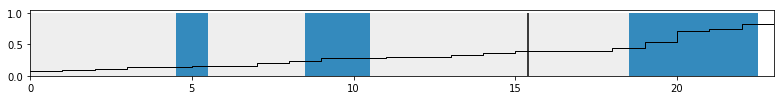

In [139]:
from separation_plot import separation_plot


figsize(11., 1.5)
separation_plot(posterior_probability, D)

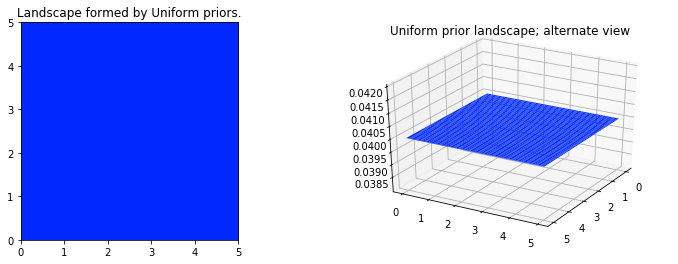

In [140]:

%matplotlib inline
import scipy.stats as stats
from IPython.core.pylabtools import figsize
import numpy as np
figsize(12.5, 4)

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

jet = plt.cm.jet
fig = plt.figure()
x = y = np.linspace(0, 5, 100)
X, Y = np.meshgrid(x, y)

plt.subplot(121)
uni_x = stats.uniform.pdf(x, loc=0, scale=5)
uni_y = stats.uniform.pdf(y, loc=0, scale=5)
M = np.dot(uni_y[:, None], uni_x[None, :])
im = plt.imshow(M, interpolation='none', origin='lower',
                cmap=jet, vmax=1, vmin=-.15, extent=(0, 5, 0, 5))

plt.xlim(0, 5)
plt.ylim(0, 5)
plt.title("Landscape formed by Uniform priors.")

ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(X, Y, M, cmap=plt.cm.jet, vmax=1, vmin=-.15)
ax.view_init(azim=390)
plt.title("Uniform prior landscape; alternate view");

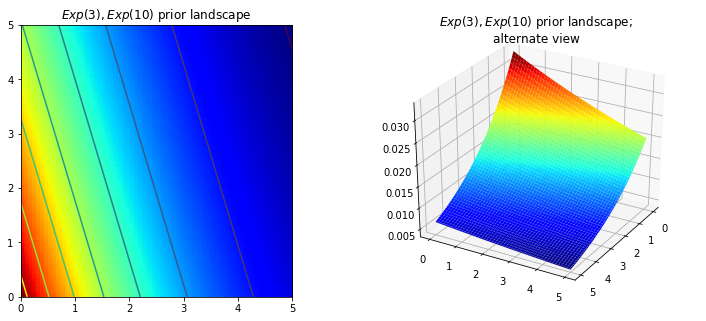

In [141]:

figsize(12.5, 5)
fig = plt.figure()
plt.subplot(121)

exp_x = stats.expon.pdf(x, scale=3)
exp_y = stats.expon.pdf(x, scale=10)
M = np.dot(exp_y[:, None], exp_x[None, :])
CS = plt.contour(X, Y, M)
im = plt.imshow(M, interpolation='none', origin='lower',
                cmap=jet, extent=(0, 5, 0, 5))
#plt.xlabel("prior on $p_1$")
#plt.ylabel("prior on $p_2$")
plt.title("$Exp(3), Exp(10)$ prior landscape")

ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(X, Y, M, cmap=jet)
ax.view_init(azim=390)
plt.title("$Exp(3), Exp(10)$ prior landscape; \nalternate view");

In [211]:

# create the observed data

# sample size of data we observe, trying varying this (keep it less than 100 ;)
N = 1

# the true parameters, but of course we do not see these values...
lambda_1_true = 1
lambda_2_true = 3

#...we see the data generated, dependent on the above two values.
data = np.concatenate([
    stats.poisson.rvs(lambda_1_true, size=(N, 1)),
    stats.poisson.rvs(lambda_2_true, size=(N, 1))
], axis=1)
print("observed (2-dimensional,sample size = %d):" % N, data)

# plotting details.
x = y = np.linspace(.01, 5, 100)
likelihood_x = np.array([stats.poisson.pmf(data[:, 0], _x)
                        for _x in x]).prod(axis=1)
likelihood_y = np.array([stats.poisson.pmf(data[:, 1], _y)
                        for _y in y]).prod(axis=1)
L = np.dot(likelihood_x[:, None], likelihood_y[None, :])
print(likelihood_x)


observed (2-dimensional,sample size = 1): [[1 5]]
[ 0.01   0.057  0.099  0.137  0.171  0.202  0.229  0.252  0.273  0.292
  0.307  0.321  0.332  0.342  0.35   0.356  0.361  0.364  0.367  0.368
  0.368  0.367  0.365  0.363  0.36   0.357  0.353  0.348  0.343  0.338
  0.332  0.326  0.32   0.314  0.308  0.301  0.294  0.288  0.281  0.274
  0.267  0.26   0.254  0.247  0.24   0.233  0.227  0.22   0.214  0.208
  0.202  0.195  0.189  0.184  0.178  0.172  0.167  0.161  0.156  0.151
  0.146  0.141  0.136  0.132  0.127  0.123  0.119  0.115  0.111  0.107
  0.103  0.099  0.096  0.092  0.089  0.086  0.082  0.079  0.077  0.074
  0.071  0.068  0.066  0.063  0.061  0.059  0.056  0.054  0.052  0.05
  0.048  0.046  0.045  0.043  0.041  0.04   0.038  0.037  0.035  0.034]


(0, 5)

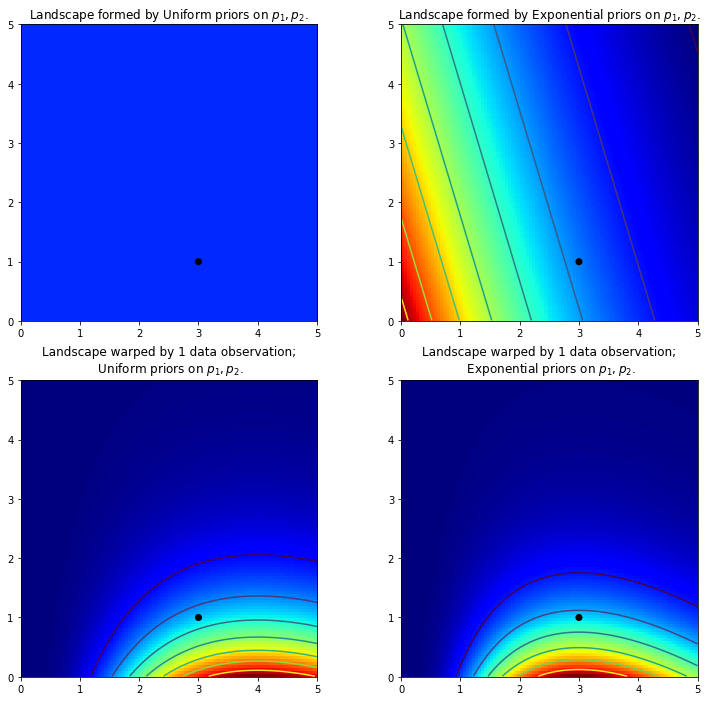

In [205]:
figsize(12.5, 12)
# matplotlib heavy lifting below, beware!
plt.subplot(221)
uni_x = stats.uniform.pdf(x, loc=0, scale=5)
uni_y = stats.uniform.pdf(x, loc=0, scale=5)
M = np.dot(uni_y[:, None], uni_x[None, :])
im = plt.imshow(M, interpolation='none', origin='lower',
                cmap=jet, vmax=1, vmin=-.15, extent=(0, 5, 0, 5))
plt.scatter(lambda_2_true, lambda_1_true, c="k", s=50, edgecolor="none")
plt.xlim(0, 5)
plt.ylim(0, 5)
plt.title("Landscape formed by Uniform priors on $p_1, p_2$.")

plt.subplot(223)
plt.contour(x, y, M * L)
im = plt.imshow(M * L, interpolation='none', origin='lower',
                cmap=jet, extent=(0, 5, 0, 5))
plt.title("Landscape warped by %d data observation;\n Uniform priors on $p_1, p_2$." % N)
plt.scatter(lambda_2_true, lambda_1_true, c="k", s=50, edgecolor="none")
plt.xlim(0, 5)
plt.ylim(0, 5)

plt.subplot(222)
exp_x = stats.expon.pdf(x, loc=0, scale=3)
exp_y = stats.expon.pdf(x, loc=0, scale=10)
M = np.dot(exp_y[:, None], exp_x[None, :])

plt.contour(x, y, M)
im = plt.imshow(M, interpolation='none', origin='lower',
                cmap=jet, extent=(0, 5, 0, 5))
plt.scatter(lambda_2_true, lambda_1_true, c="k", s=50, edgecolor="none")
plt.xlim(0, 5)
plt.ylim(0, 5)
plt.title("Landscape formed by Exponential priors on $p_1, p_2$.")

plt.subplot(224)
# This is the likelihood times prior, that results in the posterior.
plt.contour(x, y, M * L)
im = plt.imshow(M * L, interpolation='none', origin='lower',
                cmap=jet, extent=(0, 5, 0, 5))

plt.scatter(lambda_2_true, lambda_1_true, c="k", s=50, edgecolor="none")
plt.title("Landscape warped by %d data observation;\n Exponential priors on \
$p_1, p_2$." % N)
plt.xlim(0, 5)
plt.ylim(0, 5)

[ 115.857  152.262  178.874  162.935  107.028  105.191  118.383  125.377
  102.881  206.713] ...


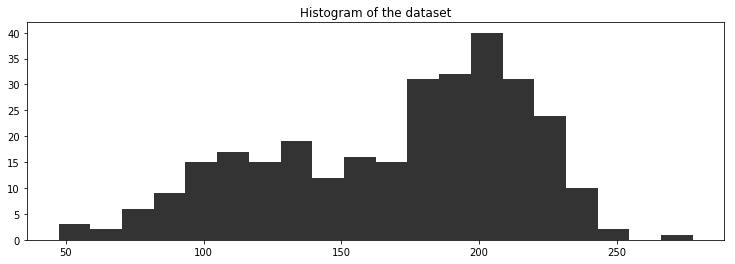

In [212]:
figsize(12.5, 4)
data = np.loadtxt("mixture_data.csv", delimiter=",")

plt.hist(data, bins=20, color="k", histtype="stepfilled", alpha=0.8)
plt.title("Histogram of the dataset")
plt.ylim([0, None])
print(data[:10], "...")

In [216]:

import pymc as pm

p = pm.Uniform("p", 0, 1)

assignment = pm.Categorical("assignment", [p, 1 - p], size=data.shape[0])
print("prior assignment, with p = %.2f:" % p.value)
print(assignment.value[:10], "...")

prior assignment, with p = 0.46:
[0 1 0 0 0 0 0 1 0 1] ...


In [217]:
stds = pm.Uniform("stds", 0, 100, size=2)
taus = 1.0 / stds ** 2
centers = pm.Normal("centers", [120, 190], [0.01, 0.01], size=2)

"""
The below deterministic functions map an assignment, in this case 0 or 1,
to a set of parameters, located in the (1,2) arrays `taus` and `centers`.
"""

@pm.deterministic
def center_i(assignment=assignment, centers=centers):
    return centers[assignment]

@pm.deterministic
def tau_i(assignment=assignment, taus=taus):
    return taus[assignment]

print("Random assignments: ", assignment.value[:4], "...")
print("Assigned center: ", center_i.value[:4], "...")
print("Assigned precision: ", tau_i.value[:4], "...")

Random assignments:  [0 1 0 0] ...
Assigned center:  [  99.177  186.16    99.177   99.177] ...
Assigned precision:  [ 0.001  0.     0.001  0.001] ...


In [218]:

# and to combine it with the observations:
observations = pm.Normal("obs", center_i, tau_i, value=data, observed=True)

# below we create a model class
model = pm.Model([p, assignment, observations, taus, centers])

In [219]:

mcmc = pm.MCMC(model)
mcmc.sample(50000)

 [-----------------100%-----------------] 50000 of 50000 complete in 20.0 sec

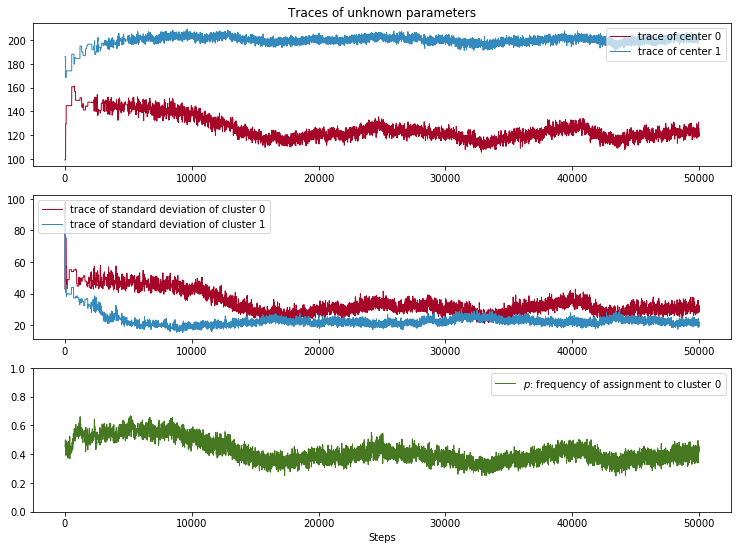

In [220]:
figsize(12.5, 9)
plt.subplot(311)
lw = 1
center_trace = mcmc.trace("centers")[:]

# for pretty colors later in the book.
colors = ["#348ABD", "#A60628"] \
if center_trace[-1, 0] > center_trace[-1, 1] \
    else ["#A60628", "#348ABD"]

plt.plot(center_trace[:, 0], label="trace of center 0", c=colors[0], lw=lw)
plt.plot(center_trace[:, 1], label="trace of center 1", c=colors[1], lw=lw)
plt.title("Traces of unknown parameters")
leg = plt.legend(loc="upper right")
leg.get_frame().set_alpha(0.7)

plt.subplot(312)
std_trace = mcmc.trace("stds")[:]
plt.plot(std_trace[:, 0], label="trace of standard deviation of cluster 0",
     c=colors[0], lw=lw)
plt.plot(std_trace[:, 1], label="trace of standard deviation of cluster 1",
     c=colors[1], lw=lw)
plt.legend(loc="upper left")

plt.subplot(313)
p_trace = mcmc.trace("p")[:]
plt.plot(p_trace, label="$p$: frequency of assignment to cluster 0",
     color="#467821", lw=lw)
plt.xlabel("Steps")
plt.ylim(0, 1)
plt.legend();

In [221]:
mcmc.sample(100000)

 [-----------------100%-----------------] 100000 of 100000 complete in 41.2 sec

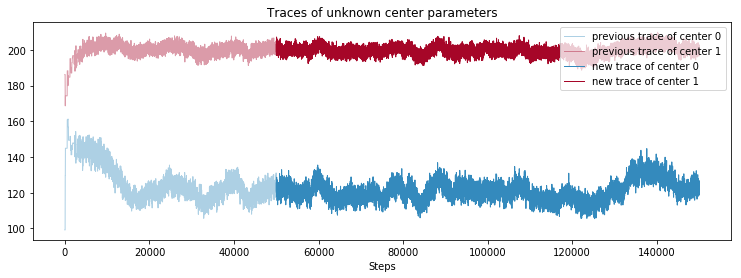

In [222]:
figsize(12.5, 4)
center_trace = mcmc.trace("centers", chain=1)[:]
prev_center_trace = mcmc.trace("centers", chain=0)[:]

x = np.arange(50000)
plt.plot(x, prev_center_trace[:, 0], label="previous trace of center 0",
     lw=lw, alpha=0.4, c=colors[1])
plt.plot(x, prev_center_trace[:, 1], label="previous trace of center 1",
     lw=lw, alpha=0.4, c=colors[0])

x = np.arange(50000, 150000)
plt.plot(x, center_trace[:, 0], label="new trace of center 0", lw=lw, c="#348ABD")
plt.plot(x, center_trace[:, 1], label="new trace of center 1", lw=lw, c="#A60628")

plt.title("Traces of unknown center parameters")
leg = plt.legend(loc="upper right")
leg.get_frame().set_alpha(0.8)
plt.xlabel("Steps");

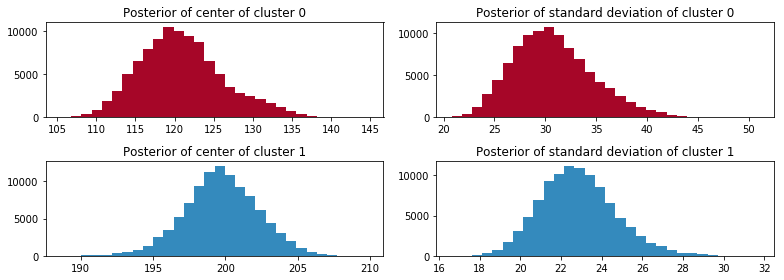

In [223]:
figsize(11.0, 4)
std_trace = mcmc.trace("stds")[:]

_i = [1, 2, 3, 4]
for i in range(2):
    plt.subplot(2, 2, _i[2 * i])
    plt.title("Posterior of center of cluster %d" % i)
    plt.hist(center_trace[:, i], color=colors[i], bins=30,
             histtype="stepfilled")

    plt.subplot(2, 2, _i[2 * i + 1])
    plt.title("Posterior of standard deviation of cluster %d" % i)
    plt.hist(std_trace[:, i], color=colors[i], bins=30,
             histtype="stepfilled")
    # plt.autoscale(tight=True)

plt.tight_layout()

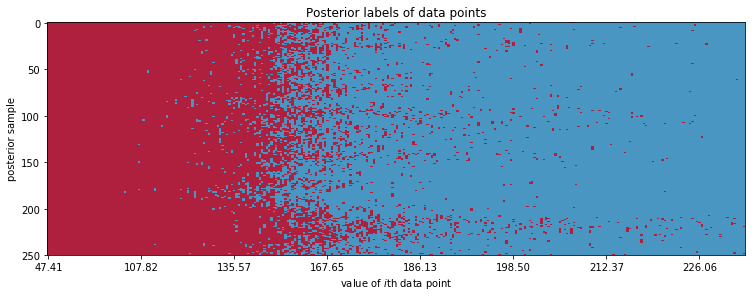

In [224]:
import matplotlib as mpl
figsize(12.5, 4.5)
plt.cmap = mpl.colors.ListedColormap(colors)
plt.imshow(mcmc.trace("assignment")[::400, np.argsort(data)],
       cmap=plt.cmap, aspect=.4, alpha=.9)
plt.xticks(np.arange(0, data.shape[0], 40),
       ["%.2f" % s for s in np.sort(data)[::40]])
plt.ylabel("posterior sample")
plt.xlabel("value of $i$th data point")
plt.title("Posterior labels of data points");

In [225]:
len(data)

300

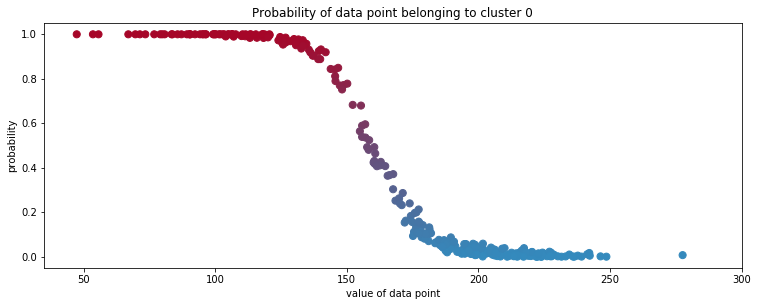

In [226]:

cmap = mpl.colors.LinearSegmentedColormap.from_list("BMH", colors)
assign_trace = mcmc.trace("assignment")[:]
plt.scatter(data, 1 - assign_trace.mean(axis=0), cmap=cmap,
        c=assign_trace.mean(axis=0), s=50)
plt.ylim(-0.05, 1.05)
plt.xlim(35, 300)
plt.title("Probability of data point belonging to cluster 0")
plt.ylabel("probability")
plt.xlabel("value of data point");

In [240]:
norm_pdf = stats.norm.pdf
p_trace = mcmc.trace("p")[:]
x = 175

v = p_trace * norm_pdf(x, loc=center_trace[:, 0], scale=std_trace[:, 0]) > \
    (1 - p_trace) * norm_pdf(x, loc=center_trace[:, 1], scale=std_trace[:, 1])

print("Probability of belonging to cluster 1:", v.mean())

Probability of belonging to cluster 1: 0.00081


In [239]:
print(v[:1000])

[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False Fa

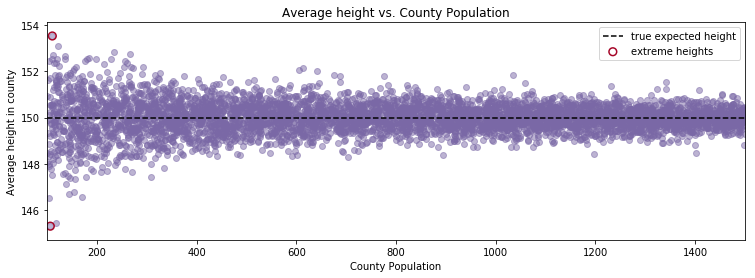

In [242]:

figsize(12.5, 4)
std_height = 15
mean_height = 150

n_counties = 5000
pop_generator = pm.rdiscrete_uniform
norm = pm.rnormal

# generate some artificial population numbers
population = pop_generator(100, 1500, size=n_counties)

average_across_county = np.zeros(n_counties)
for i in range(n_counties):
    # generate some individuals and take the mean
    average_across_county[i] = norm(mean_height, 1. / std_height ** 2,
                                    size=population[i]).mean()

# located the counties with the apparently most extreme average heights.
i_min = np.argmin(average_across_county)
i_max = np.argmax(average_across_county)

# plot population size vs. recorded average
plt.scatter(population, average_across_county, alpha=0.5, c="#7A68A6")
plt.scatter([population[i_min], population[i_max]],
            [average_across_county[i_min], average_across_county[i_max]],
            s=60, marker="o", facecolors="none",
            edgecolors="#A60628", linewidths=1.5,
            label="extreme heights")

plt.xlim(100, 1500)
plt.title("Average height vs. County Population")
plt.xlabel("County Population")
plt.ylabel("Average height in county")
plt.plot([100, 1500], [150, 150], color="k", label="true expected \
height", ls="--")
plt.legend(scatterpoints=1);